# SVD and time series 


The following function generates an $m \times n$ matrix that represents the evolution of $n$ quantities over the course of $m$ days, e.g. stocks, temperatures. 

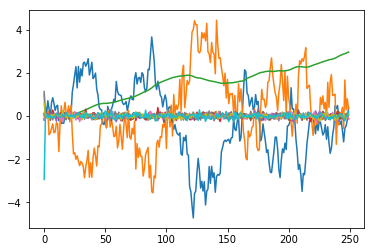

In [1]:
import numpy as np 

def generate_data(m, n):
    T = np.zeros((m,m))
    T[0,0] = 1.001
    T[1,0] = -1.001
    T[2,0] = .01
    T[2,2] = 1.01

    F = 0.1*np.ones(m)
    F[0] = 0.5
    F[1] = 0.5
    F[2] = 0.0

    np.random.seed(42)    

    Xt = np.random.uniform(size=(m,n))
    Xt[:,0] = np.random.normal(size=m)
    Xt[0,0] = .1
    Xt[1,0] = 1
    Xt[2] = .01
    
    for i in range(1,n):
        # this builds up the time correlations:
        Xt[:,i] = np.dot(T,Xt[:,i-1]) + F*np.random.normal(size=m) 
    
    return Xt.T # transpose so that rows represent time 

import matplotlib.pyplot as plt 
%matplotlib inline 

X = generate_data(10,250) # 10 quantities tracked over 250 days
_ = plt.plot(X)

### Problem

Plot the time series for the first two quantities only. 

### Solution 

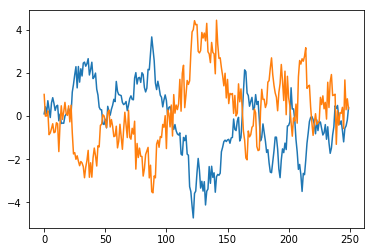

In [2]:
_ = plt.plot(X[:,:2])

It is clear that if one goes up, the other generally goes down. 

### Problem 

How would you detect this anti correlation? One approach is to ask if one trajectory is just the negative of the other. Compute the norm of `X[:,0] + X[:,0]`. Deduce that one trajectory is not just the negative of the other.

### Solution 



In [3]:
print 'norm of sum of first two trajs: '
print np.linalg.norm(X[:,0] + X[:,1])

norm of sum of first two trajs: 
10.8701189069


OK. So based on this metric, we wouldn't conclude that there is an anti-correlation. But what if the anti-correlation is polluted by noise ? These are noisy trajectories after all. 

SVD can address this problem by filtering out the noise! The basic idea is to compute the directions of maximum variability in the data and project the data onto the vector subspace defined by those directions. The remaining directions, which capture the fine-scale variability of the data, are thus filtered out. 


### Problem 

Fill in the following code that performs a SVD of the data and computes `X_approx`, which projects the data onto the first $k$ principal eigenvectors. What is the norm of `X_approx[:,0] + X_approx[:,0]`? Interpret your result. 

### Solution 

norm of sum of approximations of first two trajs: 
0.900916033289


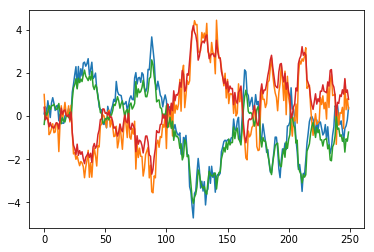

In [4]:
import scipy.linalg 

def create_Sigma(U,s,Vt): 
    m = len(U)
    n = len(Vt)
    Sigma = np.zeros((m, n))
    for i in range(min(m, n)):
        Sigma[i, i] = s[i]
    return Sigma
    
def compare_exact_to_approximation(trajectories, s_cutoff):           
    # SVD
    U, s, Vt = scipy.linalg.svd(X)
    Sigma = create_Sigma(U,s,Vt)

    # project data onto s_cutoff principal eigenvectors
    X_approx = np.dot(U[:,:s_cutoff], Sigma[:s_cutoff,:s_cutoff]).dot(Vt[:s_cutoff,:]) 

    # compare exact and approximated trajectories
    plt.plot(X[:,trajectories])
    plt.plot(X_approx[:,trajectories])
    
    return X_approx

X_approx = compare_exact_to_approximation(trajectories=[0,1], s_cutoff=1)

print 'norm of sum of approximations of first two trajs: '
print np.linalg.norm(X_approx[:,0] + X_approx[:,1])

Notice now that the approximate trajectories are a good deal more anti-correlated than the exact trajectories. Thus approximating time courses via SVD filters out noise and allows us to spot correlations more easily. 

Trajectories 0 and 1 represent components of data vectors. These components don't shift very much when the data is projected onto the vector subspace spanned by the first eigenvector. (This is what `compare_exact_to_approximation` does when `s_cutoff=1`.)  For these components, the first-order approximation is good. 

Now look at trajectory 2: 

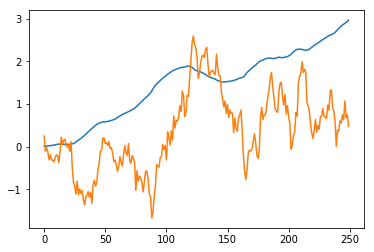

In [5]:
_ = compare_exact_to_approximation(trajectories=2, s_cutoff=1)

Trajectory 2 represents a component that does shift alot when data are projected onto the vector subspace spanned by the first principal eigenvector. In other words the approximation is poor for such data. 

### Problem 

Remedy the poor approximation of trajectory 2 by projecting the data onto the vector subspace spanned by the first two principal eigenvectors. 

### Solution 

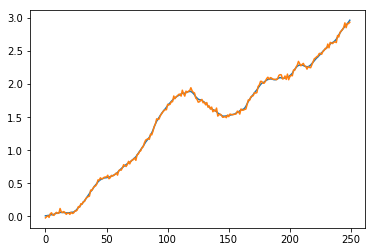

In [6]:
_ = compare_exact_to_approximation(trajectories=2, s_cutoff=2)